In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [2]:
# Open dataset and normalize data
df = pd.read_csv('joesley_day.csv', index_col=['Date'])
df = df.loc['2017-01-16':, :]
#df_norm = np.log(df / df.shift(1)).dropna()
df_norm = df.pct_change().dropna()

print(df_norm.shape)
df_norm.tail(10)

(105, 44)


,ARGT,COLO,ECH,EDEN,EFNL,EIDO,EIRL,EIS,ENZL,EPHE,EPOL,EPU,EWA,EWC,EWD,EWG,EWH,EWI,EWJ,EWK,EWL,EWM,EWN,EWO,EWP,EWQ,EWS,EWT,EWU,EWW,EWY,EWZ,EZA,GREK,INDA,KSA,MCHI,NORW,QAT,SPY,THD,TUR,UAE,VNM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-06-05,-0.002594,-0.000993,0.000459,-0.004522,-0.005153,0.000737,-0.005385,0.000939,0.000000,0.007475,-0.016907,0.004959,0.000460,0.000380,-0.008944,-0.005365,-0.007497,-0.013757,-0.003825,-0.007261,-0.011306,0.005537,-0.008035,-0.006948,-0.004452,-0.009030,-0.006245,0.006009,-0.001724,0.027885,-0.002330,-0.010879,0.009068,-0.009221,0.000607,0.003214,-0.001652,-0.007410,-0.090958,-0.000737,-0.003803,-0.013324,-0.015919,-0.003422
2017-06-06,0.002926,0.005964,0.005048,-0.000783,-0.003453,-0.006627,-0.005414,-0.001875,0.006419,-0.005829,0.012165,0.008708,-0.011045,0.005313,-0.006113,-0.007931,0.011330,0.002504,0.000731,-0.006338,-0.003716,0.000918,-0.004387,0.006063,-0.005069,-0.005737,-0.000838,-0.001138,-0.002591,-0.003929,0.000000,0.011867,-0.023366,-0.023785,-0.003640,0.005607,0.004597,-0.005710,0.010645,-0.003197,0.004581,0.005305,0.011765,0.006181
2017-06-07,-0.004862,-0.003953,-0.004110,-0.006584,0.006931,-0.000742,-0.000907,0.001503,-0.003079,0.001866,-0.000414,0.000000,0.000000,-0.011702,0.003808,0.000640,-0.002074,-0.000714,-0.000365,-0.000981,-0.003156,-0.001222,0.005085,0.003709,0.005394,0.002037,-0.001258,-0.001139,0.000577,0.003193,-0.009927,0.002288,-0.007194,-0.009534,0.001218,-0.005178,0.003112,0.000442,-0.007841,0.001850,-0.003294,-0.014392,0.010291,-0.000683
2017-06-08,-0.004560,-0.004960,-0.001605,-0.002525,-0.007375,0.000742,-0.000908,0.006753,0.002427,-0.003724,0.010365,0.001439,0.004653,0.004584,-0.002334,-0.002876,0.005405,0.012138,-0.002376,-0.005403,-0.009211,0.003978,-0.002361,-0.004157,0.006855,-0.004743,0.003778,0.004561,-0.003750,-0.001311,0.006930,-0.004281,-0.011459,0.010695,0.001824,-0.006004,0.018248,-0.001324,0.023237,0.000493,0.003305,0.012655,0.000000,-0.000683
2017-06-09,-0.011126,0.001994,0.001607,-0.000475,-0.000743,-0.011861,-0.008407,-0.001491,-0.006162,-0.003204,-0.009028,0.004597,-0.000926,0.007985,0.003217,0.002564,-0.002068,-0.004233,-0.008978,-0.000988,0.000000,-0.002133,-0.001690,0.003711,-0.004144,0.000000,0.001255,-0.013053,-0.010133,0.000375,-0.005125,-0.018630,0.001534,0.003175,-0.006980,0.001168,-0.013441,0.002652,0.009798,-0.001518,-0.007727,-0.003845,0.006503,-0.007519
2017-06-12,-0.012243,-0.005970,0.003210,-0.002057,-0.004708,0.006377,-0.006875,-0.006344,-0.000221,-0.002679,-0.010766,-0.016018,-0.000927,0.002640,-0.009330,-0.005115,-0.009532,-0.004605,0.003143,-0.007909,-0.004067,0.000916,-0.008804,-0.010166,-0.007729,-0.009190,-0.002089,-0.006900,-0.004680,0.004310,-0.010450,-0.011390,0.001362,0.008439,-0.001528,-0.009292,-0.008356,-0.003086,-0.010845,-0.000206,0.002936,0.019301,-0.009720,-0.006887
2017-06-13,0.003685,0.004004,0.007313,0.014433,0.012450,0.007082,0.011076,0.009953,0.008195,0.000269,0.007953,0.007849,0.021810,0.006396,0.010889,0.006748,0.008368,0.008185,0.005529,0.008470,0.007585,0.001221,0.005808,0.006536,0.006591,0.009275,0.008372,0.005211,0.005877,0.002426,0.013536,0.003250,0.003570,0.026151,0.003367,-0.000325,0.000733,0.011942,-0.000577,0.004890,0.011584,0.001657,0.000000,0.006935
2017-06-14,-0.013351,-0.002991,-0.002722,-0.000156,-0.000984,0.011473,0.001597,0.003161,0.007689,0.003222,-0.009551,-0.011249,0.009537,-0.012336,-0.001456,0.003830,-0.005394,-0.002824,-0.000550,0.000494,-0.002027,0.002743,0.001019,-0.009740,-0.005357,-0.000681,-0.002491,-0.004320,-0.002629,0.008377,0.005724,0.010601,0.006944,-0.006116,0.003051,-0.002031,-0.004393,-0.004808,0.012702,-0.001268,0.000629,0.005671,0.000000,0.003443
2017-06-15,-0.015562,-0.002000,-0.010237,-0.019859,-0.015017,0.001098,-0.010708,-0.009268,-0.001308,-0.004283,-0.018030,-0.023337,-0.007647,-0.003785,-0.018076,-0.016534,-0.005006,-0.010620,-0.009719,-0.018272,-0.005802,-0.003040,-0.013234,-0.016394,-0.015260,-0.012602,-0.011652,-0.005785,-0.008201,-0.007199,-0.01648

In [3]:
# Definir a data da notícia (tratamento)
treatment_date = "2017-05-17"
t0 = df_norm.index.get_loc(treatment_date)

In [4]:
# Série tratada
Y1 = df_norm["EWZ"].values

In [5]:
# Controles
donors = df_norm.drop(columns=["EWZ"])
Y0 = donors.values.T  # (unidades x tempo)

In [6]:
T0 = t0  # número de períodos pré-tratamento
Y1_pre = Y1[:T0]
Y0_pre = Y0[:, :T0]  # shape

k = Y0_pre.shape[0]  # número de controles

# Função objetivo: minimizar o erro quadrático
def objective(w):
    Y_synth = w @ Y0_pre
    return np.sum((Y1_pre - Y_synth) ** 2)

# Restrições:
# 1) soma dos pesos = 1
cons = ({
    "type": "eq",
    "fun": lambda w: np.sum(w) - 1
})

# 2) pesos >= 0
bounds = [(0, 1) for _ in range(k)]

# chute inicial (uniforme)
w0 = np.ones(k) / k

res = minimize(
    objective,
    w0,
    method="SLSQP",
    bounds=bounds,
    constraints=cons
)

weights = res.x


In [7]:
weights.round(4)

array([0.2152, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.0983, 0.0236, 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.3179, 0.    , 0.3424,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0026, 0.    , 0.    ])

In [8]:
selected = {
    etf: w for etf, w in zip(donors.columns, weights.round(4)) if w > 0
}
selected


{'ARGT': np.float64(0.2152),
 'EPU': np.float64(0.0983),
 'EWA': np.float64(0.0236),
 'EWW': np.float64(0.3179),
 'EZA': np.float64(0.3424),
 'TUR': np.float64(0.0026)}

In [9]:
EWZ_synth = weights @ Y0
impact = Y1[T0+1] - EWZ_synth[T0+1]
impact

np.float64(-0.14563630818504567)

In [10]:
mse = mean_squared_error(Y1[:T0], EWZ_synth[:T0])
rmse = np.sqrt(mse)

print(mse, rmse) #0.011370461757934283

0.00012928740058631 0.011370461757831562


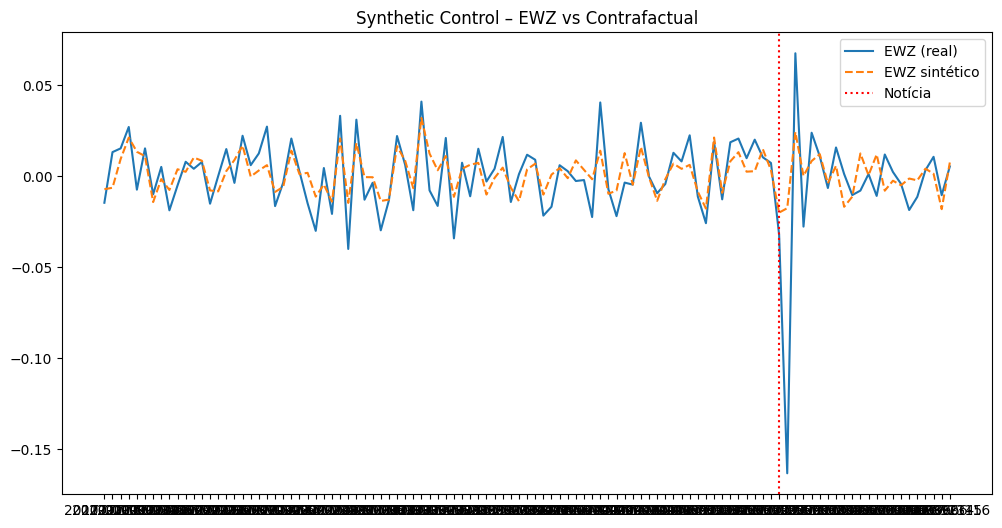

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_norm.index, Y1, label="EWZ (real)")
plt.plot(df_norm.index, EWZ_synth, label="EWZ sintético", linestyle="--")
plt.axvline(df_norm.index[t0], color="red", linestyle=":", label="Notícia")
plt.legend()
plt.title("Synthetic Control – EWZ vs Contrafactual")
plt.show()


---

https://doi.org/10.1080/13504851.2022.2140750